# Lab2 DeepConvNet

In [1]:
import os
import torch
print(torch.__version__)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from dataloader import read_bci_data

1.4.0
cuda


## TensorDataset & DataLoader

In [2]:
X_train,y_train,X_test,y_test=read_bci_data()
dataset=TensorDataset(torch.from_numpy(X_train),torch.from_numpy(y_train))
loader_train=DataLoader(dataset,batch_size=64)
dataset=TensorDataset(torch.from_numpy(X_test),torch.from_numpy(y_test))
loader_test=DataLoader(dataset,batch_size=64)
print(f'test dataset:\n{dataset[:3]}')

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)
test dataset:
(tensor([[[[ -8.3359,  -8.7829,  -9.3748,  ...,  -2.1328,  -2.8224,  -2.0885],
          [-10.6524,  -8.4476,  -5.9331,  ...,   0.5607,  -4.1266,  -8.1379]]],


        [[[ -1.6904,  -3.2816,  -3.6523,  ...,   4.0093,   0.7018,   0.7155],
          [  3.4033,   2.0698,  -1.6959,  ...,   7.7458,   3.5498,   3.7207]]],


        [[[ -2.6835,  -0.4836,   1.9848,  ...,  -3.9513,   0.4729,   5.2923],
          [  2.6602,   3.9587,   4.9871,  ...,  -0.6675,  -0.2266,   0.0633]]]],
       dtype=torch.float64), tensor([1., 0., 1.], dtype=torch.float64))


sample_id:494


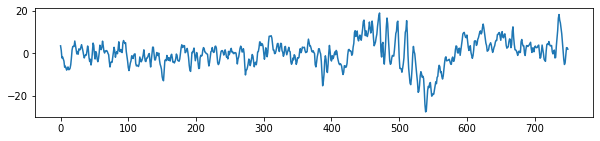

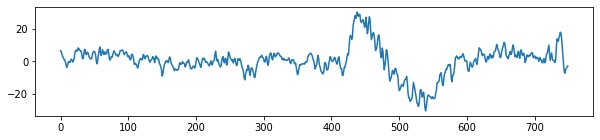

In [3]:
randi=int(np.random.randint(0,X_train.shape[0],1))
print(f'sample_id:{randi}')
plt.figure(figsize=(10,2))
plt.plot(X_train[randi,0,0])
plt.figure(figsize=(10,2))
plt.plot(X_train[randi,0,1])

## Model
![deepConvNet](deepconvnet.png)  

In [4]:
class DeepConvNet(nn.Module):
    def __init__(self,activation=nn.ELU()):
        super(DeepConvNet,self).__init__()
        self.conv0=nn.Conv2d(1,25,kernel_size=(1,5))
        channels=[25,25,50,100,200]
        kernel_sizes=[None,(2,1),(1,5),(1,5),(1,5)]
        for i in range(1,len(channels)):
            setattr(self,'conv'+str(i),nn.Sequential(
                nn.Conv2d(channels[i-1],channels[i],kernel_size=kernel_sizes[i]),
                nn.BatchNorm2d(channels[i],eps=1e-5,momentum=0.1),
                activation,
                nn.MaxPool2d(kernel_size=(1,2)),
                nn.Dropout(p=0.5)
            ))
        self.classify=nn.Linear(8600,2)
    def forward(self,X):
        out=self.conv0(X)
        out=self.conv1(out)
        out=self.conv2(out)
        out=self.conv3(out)
        out=self.conv4(out)
        out=out.view(out.shape[0],-1)
        neurons=out.shape[0]
        out=self.classify(out)
        return out

## Train
__loss function:__ cross entropy  
__optimizer:__ adam  
__learning rate:__ 0.001  
__epoch:__ 300  
__batch_size:__ 64  
__activation fuction:__ ReLU,LeakyReLU,ELU  

In [5]:
Loss=nn.CrossEntropyLoss()
lr=0.001
epochs=300

In [6]:
def train_with_different_activation(loader_train,loader_test,activations,device):
    """
    Args:
        loader_train: training dataloader
        loader_test: testing dataloader
        activations: {ReLU,LeakyReLU,ELU} pytorch layer
        device: pytorch device gpu,cpu
    Return:
        dataframe: with column 'epoch','ReLU_train','ReLU_test','LeakyReLU_train'...
    """
    df=pd.DataFrame()
    df['epoch']=range(1,epochs+1)
    for name,activation in activations.items():
        """
        train model with an specific activation function
        """
        model=DeepConvNet(activation)
        model.to(device)
        optimizer=torch.optim.Adam(model.parameters(),lr=lr)
        acc_train=list()
        acc_test=list()
        for epoch in range(1,epochs+1):
            """
            train
            """
            model.train()
            loss=0
            correct=0
            for idx,(data,target) in enumerate(loader_train):
                data=data.to(device,dtype=torch.float)
                target=target.to(device,dtype=torch.long) #target type has to be 'long'
                predict=model(data)
                loss+=Loss(predict,target)
                correct+=predict.max(dim=1)[1].eq(target).cpu().sum()
                """
                update
                """
                optimizer.zero_grad()
                loss.backward(retain_graph=True)
                optimizer.step()
            loss/=len(loader_train.dataset)
            correct=100.*correct/len(loader_train.dataset)
            print(f'epcoh{epoch:>3d}  loss:{loss:.4f}  acc:{correct:.1f}%')
            acc_train.append(correct)
            """
            test
            """
            model.eval()
            correct=0
            for idx,(data,target) in enumerate(loader_test):
                data=data.to(device,dtype=torch.float)
                target=target.to(device,dtype=torch.long)
                predict=model(data)
                correct+=predict.max(dim=1)[1].eq(target).cpu().sum()
            correct=100.*correct/len(loader_test.dataset)
            acc_test.append(correct)
        df[name+'_train']=acc_train
        df[name+'_test']=acc_test
        torch.save(model.state_dict(),os.path.join('deepconvnet models',name+'.pt'))
    return df

In [7]:
activations={'ReLU':nn.ReLU(),'LeakyReLU':nn.LeakyReLU(),'ELU':nn.ELU()}
df=train_with_different_activation(loader_train,loader_test,activations,device)

epcoh  1  loss:0.0962  acc:49.5%
epcoh  2  loss:0.1150  acc:49.7%
epcoh  3  loss:0.3596  acc:50.0%
epcoh  4  loss:0.0960  acc:53.5%
epcoh  5  loss:0.1796  acc:48.6%
epcoh  6  loss:0.1261  acc:55.6%
epcoh  7  loss:0.0454  acc:58.7%
epcoh  8  loss:0.0626  acc:59.2%
epcoh  9  loss:0.0794  acc:52.4%
epcoh 10  loss:0.0474  acc:62.9%
epcoh 11  loss:0.0344  acc:61.9%
epcoh 12  loss:0.0342  acc:56.8%
epcoh 13  loss:0.0443  acc:58.4%
epcoh 14  loss:0.0542  acc:52.8%
epcoh 15  loss:0.0765  acc:59.1%
epcoh 16  loss:0.0485  acc:61.9%
epcoh 17  loss:0.0367  acc:60.5%
epcoh 18  loss:0.0465  acc:57.3%
epcoh 19  loss:0.0720  acc:54.2%
epcoh 20  loss:0.0377  acc:64.4%
epcoh 21  loss:0.0239  acc:63.2%
epcoh 22  loss:0.0226  acc:58.9%
epcoh 23  loss:0.0325  acc:59.8%
epcoh 24  loss:0.0372  acc:54.3%
epcoh 25  loss:0.0657  acc:59.0%
epcoh 26  loss:0.0451  acc:63.5%
epcoh 27  loss:0.0289  acc:62.2%
epcoh 28  loss:0.0370  acc:60.2%
epcoh 29  loss:0.0496  acc:57.6%
epcoh 30  loss:0.0360  acc:64.7%
epcoh 31  

epcoh250  loss:0.0049  acc:86.8%
epcoh251  loss:0.0048  acc:87.3%
epcoh252  loss:0.0049  acc:88.1%
epcoh253  loss:0.0046  acc:89.0%
epcoh254  loss:0.0045  acc:88.9%
epcoh255  loss:0.0045  acc:88.3%
epcoh256  loss:0.0045  acc:88.7%
epcoh257  loss:0.0046  acc:88.3%
epcoh258  loss:0.0049  acc:87.7%
epcoh259  loss:0.0052  acc:86.9%
epcoh260  loss:0.0061  acc:85.1%
epcoh261  loss:0.0061  acc:86.5%
epcoh262  loss:0.0050  acc:87.9%
epcoh263  loss:0.0045  acc:90.4%
epcoh264  loss:0.0042  acc:89.4%
epcoh265  loss:0.0048  acc:89.3%
epcoh266  loss:0.0044  acc:89.9%
epcoh267  loss:0.0039  acc:90.6%
epcoh268  loss:0.0040  acc:90.2%
epcoh269  loss:0.0047  acc:88.1%
epcoh270  loss:0.0053  acc:87.0%
epcoh271  loss:0.0059  acc:86.0%
epcoh272  loss:0.0068  acc:83.3%
epcoh273  loss:0.0065  acc:85.1%
epcoh274  loss:0.0044  acc:90.0%
epcoh275  loss:0.0052  acc:88.0%
epcoh276  loss:0.0041  acc:90.3%
epcoh277  loss:0.0047  acc:89.3%
epcoh278  loss:0.0047  acc:88.2%
epcoh279  loss:0.0044  acc:87.9%
epcoh280  

epcoh199  loss:0.0068  acc:83.2%
epcoh200  loss:0.0112  acc:76.1%
epcoh201  loss:0.0120  acc:76.0%
epcoh202  loss:0.0085  acc:79.6%
epcoh203  loss:0.0066  acc:82.6%
epcoh204  loss:0.0060  acc:82.8%
epcoh205  loss:0.0056  acc:85.3%
epcoh206  loss:0.0056  acc:85.6%
epcoh207  loss:0.0051  acc:86.6%
epcoh208  loss:0.0056  acc:86.7%
epcoh209  loss:0.0048  acc:86.8%
epcoh210  loss:0.0055  acc:86.7%
epcoh211  loss:0.0051  acc:86.2%
epcoh212  loss:0.0045  acc:88.1%
epcoh213  loss:0.0050  acc:86.2%
epcoh214  loss:0.0048  acc:87.5%
epcoh215  loss:0.0057  acc:86.0%
epcoh216  loss:0.0062  acc:83.1%
epcoh217  loss:0.0073  acc:83.4%
epcoh218  loss:0.0064  acc:84.1%
epcoh219  loss:0.0066  acc:85.0%
epcoh220  loss:0.0046  acc:88.0%
epcoh221  loss:0.0048  acc:88.6%
epcoh222  loss:0.0046  acc:88.1%
epcoh223  loss:0.0048  acc:88.1%
epcoh224  loss:0.0057  acc:85.6%
epcoh225  loss:0.0048  acc:87.1%
epcoh226  loss:0.0051  acc:88.5%
epcoh227  loss:0.0047  acc:87.2%
epcoh228  loss:0.0049  acc:88.2%
epcoh229  

epcoh148  loss:0.0070  acc:84.8%
epcoh149  loss:0.0080  acc:82.7%
epcoh150  loss:0.0089  acc:81.5%
epcoh151  loss:0.0083  acc:80.6%
epcoh152  loss:0.0072  acc:85.6%
epcoh153  loss:0.0068  acc:84.8%
epcoh154  loss:0.0066  acc:84.5%
epcoh155  loss:0.0060  acc:85.8%
epcoh156  loss:0.0060  acc:85.5%
epcoh157  loss:0.0061  acc:84.5%
epcoh158  loss:0.0070  acc:84.3%
epcoh159  loss:0.0076  acc:84.2%
epcoh160  loss:0.0067  acc:83.5%
epcoh161  loss:0.0074  acc:84.4%
epcoh162  loss:0.0067  acc:85.6%
epcoh163  loss:0.0065  acc:85.6%
epcoh164  loss:0.0065  acc:83.6%
epcoh165  loss:0.0059  acc:85.7%
epcoh166  loss:0.0066  acc:85.3%
epcoh167  loss:0.0062  acc:85.8%
epcoh168  loss:0.0062  acc:85.0%
epcoh169  loss:0.0062  acc:86.9%
epcoh170  loss:0.0059  acc:85.7%
epcoh171  loss:0.0069  acc:84.7%
epcoh172  loss:0.0072  acc:85.7%
epcoh173  loss:0.0064  acc:85.4%
epcoh174  loss:0.0060  acc:85.3%
epcoh175  loss:0.0055  acc:87.4%
epcoh176  loss:0.0053  acc:88.3%
epcoh177  loss:0.0057  acc:87.4%
epcoh178  

## Plot

In [8]:
df

epoch       ReLU_train        ReLU_test  LeakyReLU_train  \
0        1  tensor(49.5370)  tensor(51.6667)  tensor(50.9259)   
1        2  tensor(49.7222)      tensor(50.)  tensor(48.9815)   
2        3      tensor(50.)      tensor(50.)      tensor(50.)   
3        4  tensor(53.5185)  tensor(50.6481)  tensor(54.1667)   
4        5  tensor(48.6111)  tensor(58.4259)  tensor(50.9259)   
5        6  tensor(55.6481)  tensor(51.1111)  tensor(51.6667)   
6        7  tensor(58.7037)      tensor(60.)  tensor(54.4444)   
7        8  tensor(59.1667)  tensor(60.0926)  tensor(51.2963)   
8        9  tensor(52.4074)  tensor(61.2963)  tensor(52.2222)   
9       10  tensor(62.8704)  tensor(60.8333)  tensor(55.4630)   
10      11  tensor(61.9444)  tensor(51.9444)  tensor(51.3889)   
11      12  tensor(56.7593)  tensor(57.7778)  tensor(54.2593)   
12      13  tensor(58.4259)  tensor(57.0370)  tensor(57.7778)   
13      14  tensor(52.7778)  tensor(64.0741)  tensor(51.3889)   
14      15  tensor(59.0741)  tensor(62.2222)  tensor(54.5370)   
15      16  tensor(61.9444)  tensor(52.5000)  tensor(58.3333)   
16      17  tensor(60.4630)  tensor(59.3519)  tensor(54.0741)   
17      18  tensor(57.3148)  tensor(58.9815)  tensor(55.0926)   
18      19  tensor(54.1667)  tensor(61.3889)  tensor(57.4074)   
19      20  tensor(64.4444)  tensor(61.0185)  tensor(56.2037)   
20      21  tensor(63.2407)  tensor(58.2407)  tensor(55.8333)   
21      22  tensor(58.8889)  tensor(58.5185)  tensor(59.3519)   
22      23  tensor(59.8148)  tensor(58.8889)  tensor(58.7037)   
23      24  tensor(54.2593)  tensor(63.7963)  tensor(56.8519)   
24      25  tensor(58.9815)  tensor(61.6667)  tensor(56.6667)   
25      26  tensor(63.5185)  tensor(56.4815)  tensor(64.7222)   
26      27  tensor(62.2222)  tensor(61.1111)  tensor(61.8519)   
27      28  tensor(60.1852)  tensor(62.1296)  tensor(55.7407)   
28      29  tensor(57.5926)  tensor(66.4815)  tensor(57.1296)   
29      30  tensor(64.7222)  tensor(61.3889)  tensor(61.7593)   
..     ...              ...              ...              ...   
270    271  tensor(86.0185)  tensor(74.5370)  tensor(90.8333)   
271    272  tensor(83.3333)  tensor(73.1481)  tensor(88.7963)   
272    273  tensor(85.0926)  tensor(72.5926)  tensor(89.6296)   
273    274      tensor(90.)  tensor(73.7963)  tensor(88.7037)   
274    275  tensor(87.9630)  tensor(73.9815)  tensor(86.4815)   
275    276  tensor(90.2778)  tensor(73.8889)  tensor(86.0185)   
276    277  tensor(89.2593)  tensor(72.5000)  tensor(86.4815)   
277    278  tensor(88.2407)  tensor(73.6111)  tensor(88.9815)   
278    279  tensor(87.8704)  tensor(72.6852)  tensor(90.9259)   
279    280  tensor(89.4444)  tensor(74.0741)  tensor(90.4630)   
280    281  tensor(90.3704)  tensor(74.2593)  tensor(91.4815)   
281    282  tensor(91.2037)  tensor(73.1481)  tensor(89.8148)   
282    283  tensor(90.9259)  tensor(73.4259)  tensor(89.4444)   
283    284  tensor(91.3889)  tensor(73.4259)  tensor(91.7593)   
284    285  tensor(90.2778)  tensor(74.0741)  tensor(90.4630)   
285    286  tensor(88.9815)  tensor(74.0741)  tensor(91.2963)   
286    287  tensor(89.1667)  tensor(73.5185)      tensor(90.)   
287    288  tensor(89.4444)  tensor(74.0741)  tensor(89.3519)   
288    289  tensor(89.9074)  tensor(73.1481)  tensor(87.2222)   
289    290  tensor(90.1852)  tensor(72.7778)  tensor(84.4444)   
290    291  tensor(91.0185)  tensor(73.4259)  tensor(86.5741)   
291    292  tensor(90.3704)  tensor(73.3333)  tensor(88.4259)   
292    293  tensor(89.8148)  tensor(71.8519)  tensor(90.9259)   
293    294  tensor(85.7407)  tensor(73.3333)  tensor(89.5370)   
294    295  tensor(81.9444)  tensor(73.8889)  tensor(89.9074)   
295    296  tensor(74.1667)  tensor(69.9074)  tensor(89.2593)   
296    297  tensor(73.4259)  tensor(65.7407)  tensor(91.2963)   
297    298  tensor(76.9444)  tensor(68.3333)  tensor(92.4074)   
298    299  tensor(82.4074)  tensor(71.5741)  tensor(91.6667)   
299    300  tensor(86.9444)  tensor(72.4

In [9]:
def plot(dataframe):
    fig=plt.figure(figsize=(10,6))
    for name in dataframe.columns[1:]:
        plt.plot('epoch',name,data=dataframe)
    plt.legend()
    plt.title('DeepConvNet')
    return fig

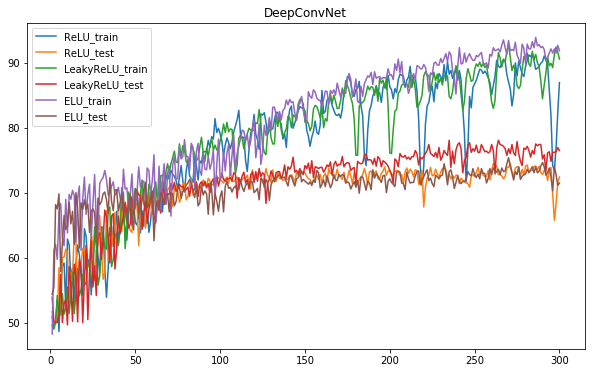

In [10]:
figure=plot(df)
figure.savefig('deepconvnet result.png')